## 필요 패키지 import

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers

In [2]:
data_path = os.getenv('HOME')+'/aiffel/pix2pix_img/cityscapes/train/'

print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


- 불러온 이미지 확인

(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)


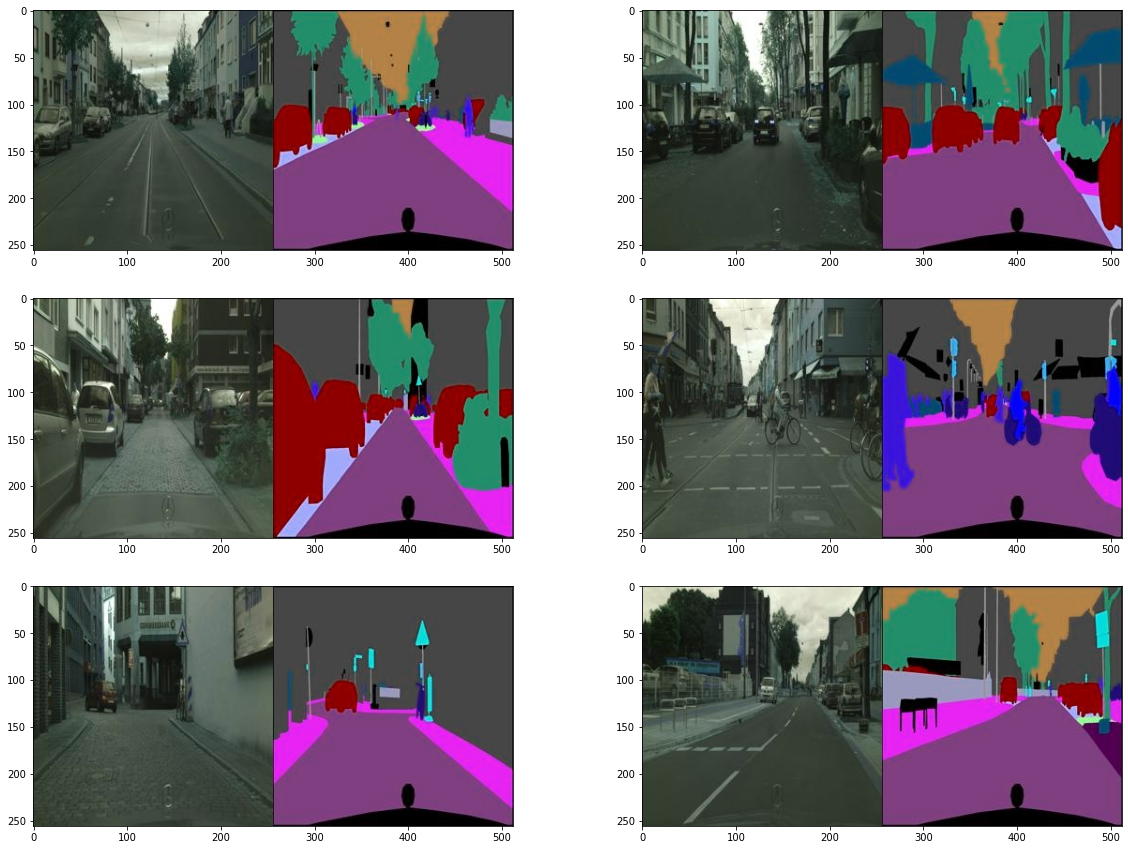

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)
    print(img.shape)

- 이미지의 크기는 (256, 512)이고, 가운대를 기준으로 왼쪽은 실제사진, 오른쪽은 그림으로 구성된 사진이다.
- 256을 기준으로 나누어서 사용하면 될듯하다.

### 이미지 나누기

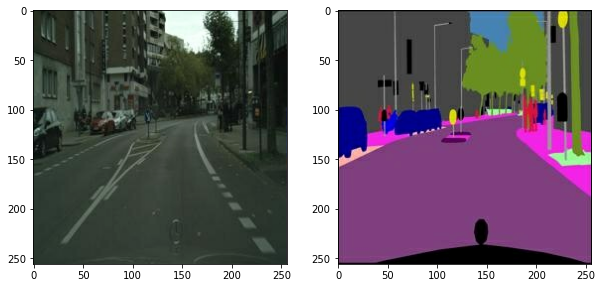

In [4]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    nomal_map = img[:, :w, :] 
    nomal_map = tf.cast(nomal_map, tf.float32)
    color_map = img[:, w:, :] 
    color_map = tf.cast(color_map, tf.float32)
    return normalize(nomal_map), normalize(color_map)

f = data_path + os.listdir(data_path)[1]
nomal_map, color_map = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(nomal_map))
plt.subplot(1,2,2); plt.imshow(denormalize(color_map))

### 필수 사항 1. 데이터 증강하기
- apply_augmentation(도로 사진, 도로 컬러)
 - 분리된 사진 연결
 - 50% 확률로 reflect(숫자 0으로), constant(0이 아닌 상수로) 옵션으로 pad를 진행한뒤, 크롭을 한다.
 - random_flip_left_right : 좌우반전
 - random_flip_up_down : 상하반전
 - 50%의 확률로 90도 회전

In [5]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(nomal_map, color_map):
    map_img = tf.concat([nomal_map, color_map], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(map_img, _pad, "REFLECT")
    else:
        padded = tf.pad(map_img, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:] 

- 결과 확인

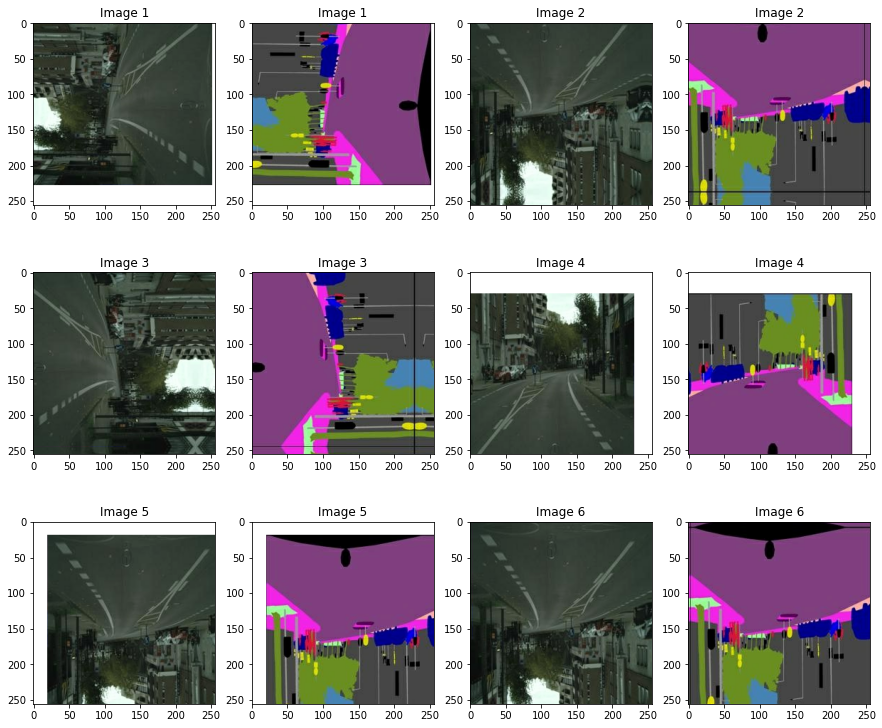

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_nomal_map, augmented_color_map = apply_augmentation(nomal_map, color_map)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_nomal_map)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_color_map)); plt.title(f"Image {img_n}")
    img_n += 1

### 데이터셋 생성

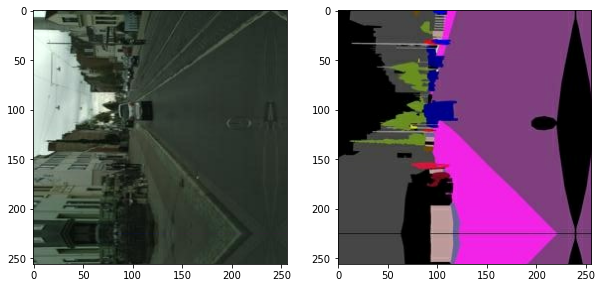

In [7]:
def get_train(img_path):
    nomal_map, color_map = load_img(img_path)
    nomal_map, color_map = apply_augmentation(nomal_map, color_map)
    return nomal_map, color_map

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
nomal_map, color_map = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(nomal_map[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(color_map[0].astype(np.uint8))

### 필수사항 2. U-Net Generator 구성하기
- encoder, decoder 사이에 features 리스트를 만들어 decoder 입력으로 넣어준다.
- 그러다보니 디코더의 파라미터가 늘어나게 된다.

In [8]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [9]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        # skip connection을 위한 추가사항 
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [10]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

### Discriminator 구현

In [11]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [12]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

### 출력의 크기 확인

In [13]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


- 이미지가 30x30 크기로 잘 나온다!

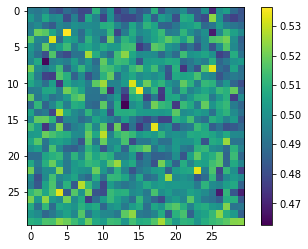

In [14]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 모델 학습하기

- loss function 정의 

In [15]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


- optimizer 정의

In [16]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

- step 별 가중치 업데이트 정의

In [17]:
@tf.function
def train_step(nomal_map, real_color_map):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_color_map = generator(nomal_map, training=True)
        # Discriminator 예측
        fake_disc = discriminator(nomal_map, fake_color_map, training=True)
        real_disc = discriminator(nomal_map, real_color_map, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 200

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[],'l1_loss':[],'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (nomal_map, color_map) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(nomal_map, color_map)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
                
        # EPOCHS 마다 손실을 출력합니다.
        if (i+1) % EPOCHS == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]                     
Generator_loss:2.0174                     
L1_loss:0.2348                     
Discriminator_loss:1.1065

EPOCH[2] - STEP[200]                     
Generator_loss:0.8227                     
L1_loss:0.2215                     
Discriminator_loss:1.1785

EPOCH[3] - STEP[200]                     
Generator_loss:3.0724                     
L1_loss:0.2076                     
Discriminator_loss:1.2805

EPOCH[4] - STEP[200]                     
Generator_loss:1.1346                     
L1_loss:0.1782                     
Discriminator_loss:0.7551

EPOCH[5] - STEP[200]                     
Generator_loss:2.6606                     
L1_loss:0.2160                     
Discriminator_loss:0.2502

EPOCH[6] - STEP[200]                     
Generator_loss:1.5779                     
L1_loss:0.1508                     
Discriminator_loss:0.5938

EPOCH[7] - STEP[200]                     
Generator_loss:2.3391                     
L1_loss:0.1839             

### 필수사항 3,4. val 데이터 셋으로 모델 인퍼런스하기
- 스케치, 생성, 실제사진 나란하게 시각화하기

In [ ]:
test_data_path = os.getenv('HOME')+'/aiffel/pix2pix_img/cityscapes/val/'

test_list = os.listdir(test_data_path)
test_list

In [ ]:
def make_road(test_ind):
    f = test_data_path + os.listdir(test_data_path)[test_ind]
    test_segmap, test_road = load_img(f)

    pred = generator(tf.expand_dims(test_segmap, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(test_segmap))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(test_road))
    plt.show()

In [ ]:
for i in range(5):
    make_road(i)

### 필수사항 5. loss값 로그 남기기

In [ ]:
plt.figure(figsize=(20,15))
plt.subplot(311)
plt.plot(history['gen_loss'], color='cornflowerblue')
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'], color='thistle')
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'], color='cadetblue')
plt.title('Discriminator Loss')

plt.show()

## 회고
- 이전 GAN에서 언급만으로 지나간 pix2pix를 실제로 구현하는 좋은 과제였다. u-net의 skip connect의 구현 방법을 알게되어 좋았다.

- 이번 과제를 진행하면서 논문을 보고 구현하는 과정을 보고, 논문을 읽는것에만 그치지 않고 구현 해보려는 훈련이 필요하다고 느꼇다.

- gan의 모델은 하이퍼 파라미터의 수정보다는 epoch을 늘리는것이 결과물에 만족도를 높히는것 같다.